## 1. Load Libraries

In [22]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

sns.set_theme()


## 2. Import Dataset

I am using Baseball Savant's MLB hitter dataset from their hitting leaderboard. This data is compiled by Major League Baseball and publicly available online for free. This dataset contains 397 observations with 76 features.

In [23]:
df = pd.read_csv("savant_logistic.csv")
df.head(20)


,pitches,player_id,player_name,total_pitches,pitch_percent,ba,iso,babip,slg,woba,...,xslgdiff,wobadiff,swing_miss_percent,arm_angle,attack_angle,attack_direction,swing_path_tilt,rate_ideal_attack_angle,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,28,650333,"Arraez, Luis",1025,2.7,0.250,0.107,0.250,0.357,0.263,...,0.058,0.039,0,30.2,4.229919,7.979895,34.393206,0.461538,34.809989,30.164862
1,24,663538,"Hoerner, Nico",995,2.4,0.250,0.000,0.250,0.250,0.222,...,-0.004,0.026,0,41.3,3.595838,1.559616,32.713145,0.416667,34.742860,25.368575
2,24,664034,"France, Ty",1059,2.3,0.417,0.083,0.417,0.500,0.402,...,-0.015,0.014,0,34.0,10.528080,2.125356,34.373016,0.708333,34.377860,29.069674
3,24,691026,"Winn, Masyn",1100,2.2,0.292,0.042,0.292,0.333,0.275,...,-0.020,0.010,0,39.2,2.743169,-2.705638,29.832229,0.434783,32.484564,33.280015
4,24,805779,"Wilson, Jacob",921,2.6,0.609,0.087,0.583,0.696,0.550,...,0.200,0.157,0,35.0,1.327720,0.180470,34.049826,0.285714,31.595549,30.759428
5,23,671218,"Ramos, Heliot",1219,1.9,0.348,0.043,0.348,0.391,0.326,...,-0.056,-0.001,0,42.7,6.388656,6.640698,33.024508,0.739130,36.054645,26.481514
6,23,681624,"Pages, Andy",1055,2.2,0.391,0.130,0.391,0.522,0.397,...,-0.038,-0.023,0,35.9,4.342947,0.307981,42.551036,0.590909,41.562035,28.990533
7,23,667670,"Rooker, Brent",1185,1.9,0.435,0.087,0.435,0.522,0.419,...,-0.005,0.032,0,34.8,7.877843,0.150324,35.388510,0.736842,37.230634,29.790469
8,23,665161,"Peña, Jeremy",1026,2.2,0.522,0.130,0.522,0.652,0.513,...,0.195,0.198,0,35.8,8.729587,-2.052036,29.275878,0.809524,38.913834,27.595161
9,23,514888,"Altuve, Jose",1012,2.3,0.227,0.000,0.217,0.227,0.193,...,-0.029,-0.035,0,38.9,12.473598,-7.091300,30.097233,0.523810,43.478194,28.642688


## 3. Define Target

In [24]:
# Define power hitter based on slugging percentage
df['is_power_hitter'] = (df['slg'] > 0.450).astype(int)
df['is_power_hitter'].value_counts()


0    303
1     95
Name: is_power_hitter, dtype: int64

I am defining a "power hitter" as any hitter with a SLG above .450. This is an arbitrary number, but also widely accepted as the threshold for a power hitter in MLB. There are 303 non-power hitters and 95 power hitters in this dataset. This makes sense, as I would agree that roughly 25% of the league should be classified as power hitters.

## 4. Feature Selection

In [25]:
features = ['launch_speed', 'launch_angle', 'attack_angle', 'swing_path_tilt', 
            'rate_ideal_attack_angle', 'intercept_ball_minus_batter_pos_x_inches',
            'intercept_ball_minus_batter_pos_y_inches']

# Drop rows with missing data
model_df = df.dropna(subset=features + ['is_power_hitter'])

X = model_df[features]
y = model_df['is_power_hitter']

Here, I am experimenting with seven different features related to a player's approach (launch/attack angles) and contact (distance between ball and batter). I expect most or all of these features to provide meaningful insight into a player's quality of contact (and, in turn, whether they are a power hitter).

## 5. Prep Train/Test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 6. Logistic Regression

In [27]:

logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train_scaled, y_train)

y_pred = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]


## 7. Regression Model Metrics

In [28]:
print(classification_report(y_test, y_pred, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob).round(3))

              precision    recall  f1-score   support

           0      0.895     0.557     0.687        61
           1      0.357     0.789     0.492        19

    accuracy                          0.613        80
   macro avg      0.626     0.673     0.589        80
weighted avg      0.767     0.613     0.641        80

ROC AUC: 0.703


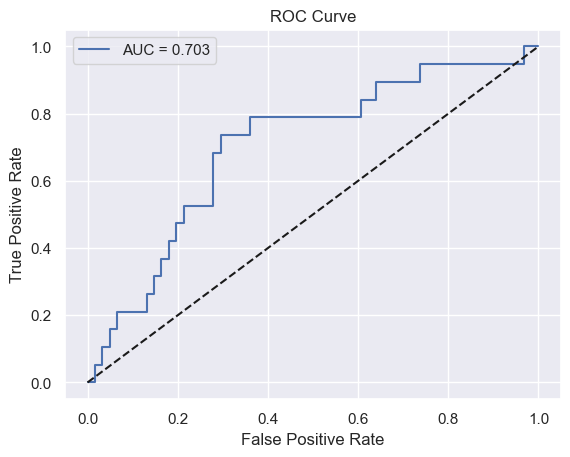

In [29]:

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


## 8. Feature Coefficients

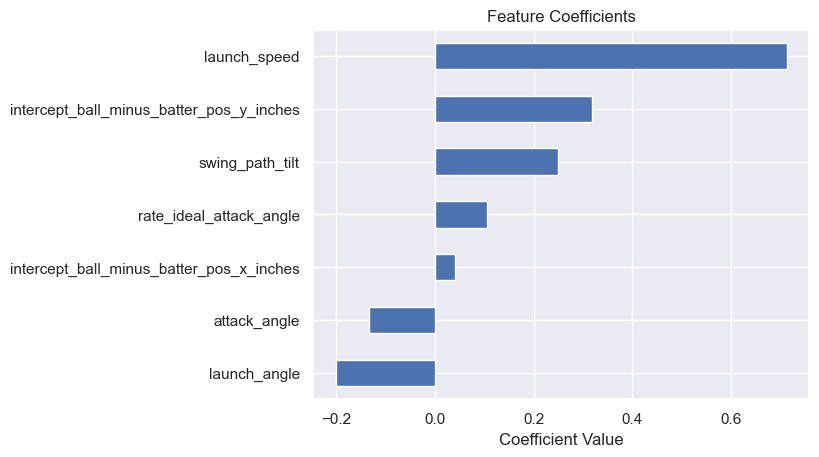

In [30]:
coefficients = pd.Series(logreg.coef_[0], index=features)
coefficients.sort_values().plot(kind='barh')
plt.title("Feature Coefficients")
plt.xlabel("Coefficient Value")
plt.grid(True)
plt.show()

Here we take a look at the strength of each feature. A larger coefficient indicates a strong positive relationship. I am not surprised that launch speed has a very strong relationship with a value of >0.7, as higher launch speed will lead to greater exit velocity and more "slug." I am a little surprised to see low negative values for attack angle and launch angle, though I suspect this may have something to do with what is commonly referred to as "swing and miss" in baseball. For example, a high launch angle will generate more home runs and big hits, but it also leads to batters missing the ball more often (more strikeouts results in lower slugging percentage).

## 9. Confusion Matrix

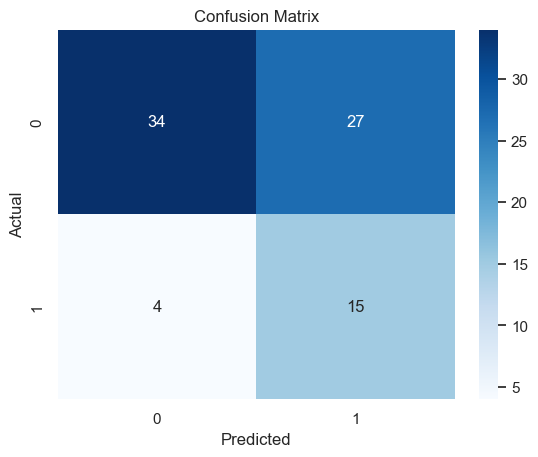

In [31]:
conf_mtx = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mtx, annot=True, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

This model with my specific features is better at avoiding false negatives (only 4) than avoiding false positives (27). In other words, it's relatively conservative when predicting "true" cases (predicting players as power hitters). 

True Negatives (34)

False Positives (27)

False Negatives (4)

True Positives (15)

I would feel confident using this model to predict non-power hitters. I would feel okay using this model to predict power hitters, but only with the understanding that it's not going to be perfect and likely requires more context or more refinement.